In [200]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, SGDRegressor, SGDClassifier, Lasso, Ridge
import sklearn.metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from lightgbm import LGBMRegressor, LGBMRegressor

from catboost import CatBoostRegressor, CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [66]:
X = pd.read_csv('not_scaler_data.csv', index_col=0)
y = pd.read_csv('data/target_data', index_col=0)
X = X[~X.isna_Al2O3].drop(['isna_SiO2', 'isna_Al2O3'], axis=1)
y = y[~y.isna_Al2O3].drop(['isna_SiO2', 'isna_Al2O3'], axis=1)

In [67]:
df = X.merge(y, how='inner', left_index=True, right_index=True)

In [123]:
y = df['сыпуч известь РП'].copy()
X = pd.get_dummies(df.drop('сыпуч известь РП', axis=1))

In [124]:
def description(df, columns):
    for name in columns:
        print(name, '\nПропущенных значений:', df[name].isna().sum(),\
              '(', round(df[name].isna().sum() * 100 / len(df[name]), 2)  ,'%)',
             '\nМедиана: {2}, Среднее значение: {0}, Ср.откл:{1}'.format(round(df[name].mean(), 3),\
                                                                         round(df[name].std(), 3),\
                                                                         df[name].median()),\
              '\nУникальных значений: {}'.format(df[name].value_counts(dropna=False).count()), '\n')
        fig = plt.figure(figsize=(10, 8))
        plt.subplot(221)
        plt.hist(df[name])
        plt.grid()
        plt.subplot(222)
        sns.boxplot(y=df[name])
        plt.show()

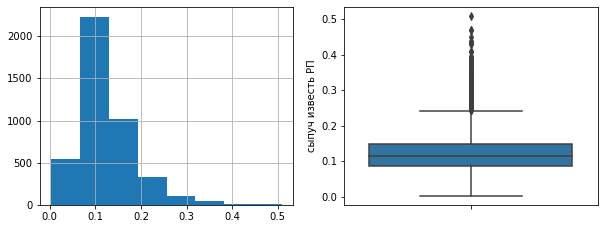

In [125]:
fig = plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.hist(y, bins=8)
plt.grid()
plt.subplot(222)
sns.boxplot(y=y)
plt.show()
plt.show('CaO')

In [126]:
(y == 0).sum()

0

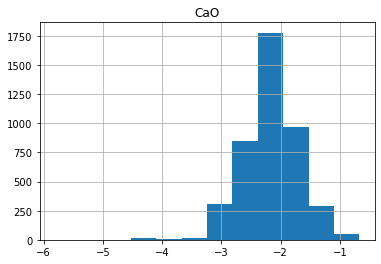

In [127]:
plt.hist(np.log(y), bins=12)
plt.title('CaO')
plt.grid()

In [131]:
(y == 0).sum()

0

In [132]:
ln_y = np.log(y)
max = ln_y.max()
min = ln_y.min()
width_class = (ln_y.max() - ln_y.min()) / 12

In [133]:
# границы классов
for i in range(13):
    print(min + i * width_class)

-5.809142990314028
-5.381323346323827
-4.9535037023336255
-4.525684058343424
-4.097864414353223
-3.670044770363022
-3.242225126372821
-2.81440548238262
-2.386585838392419
-1.9587661944022177
-1.5309465504120165
-1.1031269064218154
-0.6753072624316143


In [175]:
class_border = [[-5.809142990314029, -2.81440548238262],
                   [-2.81440548238262, -2.386585838392419],
                   [-2.386585838392419, -1.9587661944022177],
                    [-1.9587661944022177, -0.6753072624316143]]
pd.DataFrame(class_border, columns=['left', 'right']).apply(lambda x: np.exp(x))

,left,right
0,0.003000,0.059940
1,0.059940,0.091943
2,0.091943,0.141032
3,0.141032,0.509000


In [134]:
def get_class(x):
    class_border = [[-5.809142990314029, -2.81440548238262],
                   [-2.81440548238262, -2.386585838392419],
                   [-2.386585838392419, -1.9587661944022177],
                    [-1.9587661944022177, -0.6753072624316143]]
    for i in range(len(class_border)):
        left = class_border[i][0]
        right = class_border[i][1]
        if x > left and x <= right:
            return i

In [135]:
ln_y_to_class = ln_y.apply(lambda x: get_class(x))

In [136]:
ln_y_to_class.value_counts(dropna=False)

2    1777
3    1310
1     852
0     356
Name: сыпуч известь РП, dtype: int64

In [137]:
from sklearn.linear_model import LogisticRegression 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.naive_bayes import GaussianNB  
from sklearn.tree import DecisionTreeClassifier  
from sklearn.svm import SVC 

In [138]:
x_train, x_test, y_train, y_test = train_test_split(X, ln_y_to_class, test_size=0.25)

In [162]:
logreg_clf = LogisticRegression()
logreg_clf.fit(x_train, y_train)
y_pr = logreg_clf.predict(x_test)
print(accuracy_score(y_test, y_pr))
# confusion_matrix(y_test, y_pr)

0.4729981378026071


In [145]:
logreg_clf = SVC()
logreg_clf.fit(x_train, y_train)
y_pr = logreg_clf.predict(x_test)
accuracy_score(y_test, y_pr)

0.4171322160148976

In [159]:
logreg_clf = KNeighborsClassifier(n_neighbors=500)
logreg_clf.fit(x_train, y_train)
y_pr = logreg_clf.predict(x_test)
accuracy_score(y_test, y_pr)

0.425512104283054

### Только по последним химшлакам и маркам

In [166]:
X_small = X.loc[:, 'химшлак последний Al2O3':]

In [180]:
x_train, x_test, y_train, y_test = train_test_split(X_small, ln_y_to_class, test_size=0.25)

In [168]:
logreg_clf = LogisticRegression()
logreg_clf.fit(x_train, y_train)
y_pr = logreg_clf.predict(x_test)
print(accuracy_score(y_test, y_pr))
# confusion_matrix(y_test, y_pr)

0.45344506517690875


In [211]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
grid_cv = GridSearchCV(LogisticRegression(), param_grid=grid)
grid_cv.fit(x_train, y_train)
print(grid_cv.best_params_)
logreg_clf = grid_cv.best_estimator_
cross_val_score(logreg_clf, x_test, y_test, scoring='accuracy').mean()

# logreg_clf = LogisticRegression()
# logreg_clf.fit(x_train, y_train)
# y_pr = logreg_clf.predict(x_test)
# print(accuracy_score(y_test, y_pr))

{'C': 0.001, 'penalty': 'l2'}


0.445059769615301

In [169]:
logreg_clf = SVC()
logreg_clf.fit(x_train, y_train)
y_pr = logreg_clf.predict(x_test)
accuracy_score(y_test, y_pr)

0.4543761638733706

In [170]:
logreg_clf = KNeighborsClassifier(n_neighbors=500)
logreg_clf.fit(x_train, y_train)
y_pr = logreg_clf.predict(x_test)
accuracy_score(y_test, y_pr)

0.4664804469273743

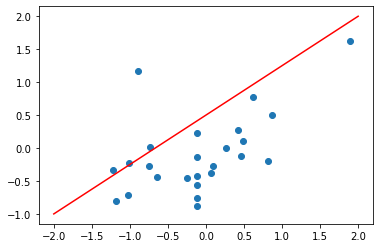

In [25]:
lg = LinearRegression()
lg.fit(x_train, y_train)
y_predicted = lg.predict(x_test)
plt.scatter(y_test, y_predicted)
plt.plot([-2, 2], [-1, 2], c='r')

In [18]:
abs(cross_val_score(LinearRegression(), X, y, scoring='neg_mean_absolute_percentage_error')).mean()

2.0653098670776404

In [26]:
from sklearn.manifold import TSNE